# 🏥 STROKE PREDICTION - PREPROCESAMIENTO ÓPTIMO

## 🚩 FLAGS:
- **ULTRA_THINK_MODE:** ✅ ENABLED
- **MODO_INGENIERO:** ✅ ENABLED

## 🎯 OBJETIVO:
Preparar dataset para modelado ML/DL con:
- ✅ Balance de clases (SMOTE)
- ✅ Feature Engineering inteligente
- ✅ Normalización adecuada
- ✅ Eliminación de features irrelevantes
- ✅ Pipeline reproducible

---

In [1]:
# 📦 IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📊 Pandas: {pd.__version__}")
print(f"🔢 NumPy: {np.__version__}")

✅ Librerías importadas correctamente
📊 Pandas: 2.3.3
🔢 NumPy: 1.26.4


In [2]:
# 📂 CARGA DE DATOS
df = pd.read_csv('../data/stroke_dataset.csv')

print("📊 DATASET ORIGINAL:")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"\n✅ Valores nulos: {df.isnull().sum().sum()}")
print(f"✅ Duplicados: {df.duplicated().sum()}")
print(f"\n⚠️  Desbalanceo:")
print(df['stroke'].value_counts())
print(f"   Ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")

📊 DATASET ORIGINAL:
   Filas: 4,981
   Columnas: 11

✅ Valores nulos: 0
✅ Duplicados: 0

⚠️  Desbalanceo:
stroke
0    4733
1     248
Name: count, dtype: int64
   Ratio: 19.08:1


---
## 🛠️ FASE 1: FEATURE ENGINEERING
### Crear features relevantes basadas en insights del EDA
---

In [3]:
# 🎯 FEATURE ENGINEERING BASADO EN INSIGHTS DEL EDA

df_processed = df.copy()

# 1. CATEGORÍAS DE EDAD (variable MÁS importante según EDA)
df_processed['age_group'] = pd.cut(df_processed['age'],
                                     bins=[0, 18, 40, 60, 100],
                                     labels=['Child', 'Young_Adult', 'Adult', 'Senior'])

# 2. CATEGORÍAS DE GLUCOSA (correlación 0.133)
df_processed['glucose_category'] = pd.cut(df_processed['avg_glucose_level'],
                                           bins=[0, 100, 125, 300],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])

# 3. CATEGORÍAS DE BMI (correlación 0.057 pero relevante)
df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. SMOKING BINARIO (simplificar - correlación débil 0.027)
df_processed['has_smoked'] = df_processed['smoking_status'].apply(
    lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0
)

# 5. RISK SCORE COMPUESTO (basado en top predictores)
# Normalizar primero las variables continuas
age_norm = (df_processed['age'] - df_processed['age'].min()) / (df_processed['age'].max() - df_processed['age'].min())
glucose_norm = (df_processed['avg_glucose_level'] - df_processed['avg_glucose_level'].min()) / (df_processed['avg_glucose_level'].max() - df_processed['avg_glucose_level'].min())
bmi_norm = (df_processed['bmi'] - df_processed['bmi'].min()) / (df_processed['bmi'].max() - df_processed['bmi'].min())

df_processed['risk_score'] = (
    age_norm * 0.35 +                    # Edad: 35% (predictor #1)
    df_processed['heart_disease'] * 0.25 + # Enfermedad cardíaca: 25%
    df_processed['hypertension'] * 0.20 +  # Hipertensión: 20%
    glucose_norm * 0.15 +                  # Glucosa: 15%
    bmi_norm * 0.05                        # BMI: 5%
)

# 6. INTERACCIONES CRÍTICAS
df_processed['age_x_hypertension'] = df_processed['age'] * df_processed['hypertension']
df_processed['age_x_heart_disease'] = df_processed['age'] * df_processed['heart_disease']
df_processed['glucose_x_bmi'] = df_processed['avg_glucose_level'] * df_processed['bmi']

print("✅ FEATURE ENGINEERING COMPLETADO:")
print(f"   Nuevas features creadas: {df_processed.shape[1] - df.shape[1]}")
print(f"   Total de columnas: {df_processed.shape[1]}")
print("\n📋 Nuevas features:")
new_features = ['age_group', 'glucose_category', 'bmi_category', 'has_smoked',
                'risk_score', 'age_x_hypertension', 'age_x_heart_disease', 'glucose_x_bmi']
for feat in new_features:
    print(f"   ✓ {feat}")

✅ FEATURE ENGINEERING COMPLETADO:
   Nuevas features creadas: 8
   Total de columnas: 19

📋 Nuevas features:
   ✓ age_group
   ✓ glucose_category
   ✓ bmi_category
   ✓ has_smoked
   ✓ risk_score
   ✓ age_x_hypertension
   ✓ age_x_heart_disease
   ✓ glucose_x_bmi


---
## 🗑️ FASE 2: ELIMINACIÓN DE FEATURES IRRELEVANTES
### Según EDA: gender (0.009) y Residence_type (0.016) tienen correlación casi nula
---

In [4]:
# 🗑️ ELIMINAR FEATURES IRRELEVANTES (correlación casi nula según EDA)

features_to_drop = ['gender', 'Residence_type', 'id']  # id no es predictor

# Verificar si 'id' existe antes de eliminar
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

print("🗑️  ELIMINANDO FEATURES IRRELEVANTES:")
for feat in features_to_drop:
    print(f"   ✗ {feat}")

df_processed = df_processed.drop(columns=features_to_drop)

print(f"\n✅ Features eliminadas: {len(features_to_drop)}")
print(f"✅ Columnas restantes: {df_processed.shape[1]}")

🗑️  ELIMINANDO FEATURES IRRELEVANTES:
   ✗ gender
   ✗ Residence_type

✅ Features eliminadas: 2
✅ Columnas restantes: 17


---
## 🔢 FASE 3: ENCODING DE VARIABLES CATEGÓRICAS
---

In [5]:
# 🔢 ENCODING DE CATEGÓRICAS

# Separar target
y = df_processed['stroke']
X = df_processed.drop('stroke', axis=1)

print("🔢 ENCODING DE VARIABLES CATEGÓRICAS:")

# Label Encoding para variables binarias
binary_features = ['ever_married']
le = LabelEncoder()
for feat in binary_features:
    if feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
        print(f"   ✓ Label Encoding: {feat}")

# One-Hot Encoding para categóricas con múltiples valores
categorical_features = ['work_type', 'smoking_status', 'age_group', 'glucose_category', 'bmi_category']
categorical_features = [f for f in categorical_features if f in X.columns]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\n✅ One-Hot Encoding aplicado a {len(categorical_features)} features")
print(f"✅ Shape después de encoding: {X.shape}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS:
   ✓ Label Encoding: ever_married

✅ One-Hot Encoding aplicado a 5 features
✅ Shape después de encoding: (4981, 25)


---
## ✂️ FASE 4: TRAIN/VALIDATION/TEST SPLIT
### Split estratificado para mantener ratio de clases
---

In [6]:
# ✂️ SPLIT ESTRATIFICADO (60/20/20)

# Primero: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Segundo: Validation (20%) vs Test (20%) del Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("✂️  SPLIT ESTRATIFICADO COMPLETADO:")
print(f"\n📊 TRAIN SET (60%):")
print(f"   Filas: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Stroke distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 VALIDATION SET (20%):")
print(f"   Filas: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_val.shape[1]}")
print(f"   Stroke distribution: {y_val.value_counts().to_dict()}")

print(f"\n📊 TEST SET (20%):")
print(f"   Filas: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Stroke distribution: {y_test.value_counts().to_dict()}")

✂️  SPLIT ESTRATIFICADO COMPLETADO:

📊 TRAIN SET (60%):
   Filas: 2,988 (60.0%)
   Features: 25
   Stroke distribution: {0: 2839, 1: 149}

📊 VALIDATION SET (20%):
   Filas: 996 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 49}

📊 TEST SET (20%):
   Filas: 997 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 50}


---
## ⚖️ FASE 5: NORMALIZACIÓN
### StandardScaler para features numéricas
---

In [7]:
# ⚖️ NORMALIZACIÓN CON STANDARDSCALER

scaler = StandardScaler()

# Fit SOLO en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("⚖️  NORMALIZACIÓN COMPLETADA:")
print(f"\n📊 Estadísticas TRAIN SCALED:")
print(f"   Media: {X_train_scaled.mean().mean():.6f} (debe ser ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (debe ser ~1)")

print(f"\n✅ Todos los conjuntos normalizados correctamente")

⚖️  NORMALIZACIÓN COMPLETADA:

📊 Estadísticas TRAIN SCALED:
   Media: 0.000000 (debe ser ~0)
   Std: 1.000167 (debe ser ~1)

✅ Todos los conjuntos normalizados correctamente


---
## 🎯 FASE 6: BALANCEO CON SMOTE
### ⚠️ CRÍTICO: Solo aplicar a TRAIN, NUNCA a validation/test
---

In [8]:
# 🎯 SMOTE - BALANCEO DE CLASES

print("⚠️  DESBALANCEO ANTES DE SMOTE:")
print(f"   Clase 0 (No stroke): {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   Clase 1 (Stroke): {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"   Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Aplicar SMOTE con ratio 2:1 (conservador)
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # 0.5 = ratio 2:1
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\n✅ BALANCEO COMPLETADO:")
print(f"   Clase 0 (No stroke): {(y_train_balanced == 0).sum()} ({(y_train_balanced == 0).sum()/len(y_train_balanced)*100:.2f}%)")
print(f"   Clase 1 (Stroke): {(y_train_balanced == 1).sum()} ({(y_train_balanced == 1).sum()/len(y_train_balanced)*100:.2f}%)")
print(f"   Ratio: {(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.2f}:1")
print(f"\n📈 Muestras sintéticas generadas: {len(y_train_balanced) - len(y_train):,}")
print(f"📊 Train set balanceado: {len(y_train_balanced):,} filas")

⚠️  DESBALANCEO ANTES DE SMOTE:
   Clase 0 (No stroke): 2839 (95.01%)
   Clase 1 (Stroke): 149 (4.99%)
   Ratio: 19.05:1

✅ BALANCEO COMPLETADO:
   Clase 0 (No stroke): 2839 (66.67%)
   Clase 1 (Stroke): 1419 (33.33%)
   Ratio: 2.00:1

📈 Muestras sintéticas generadas: 1,270
📊 Train set balanceado: 4,258 filas


---
## 📊 VISUALIZACIÓN: COMPARACIÓN ANTES/DESPUÉS SMOTE
---

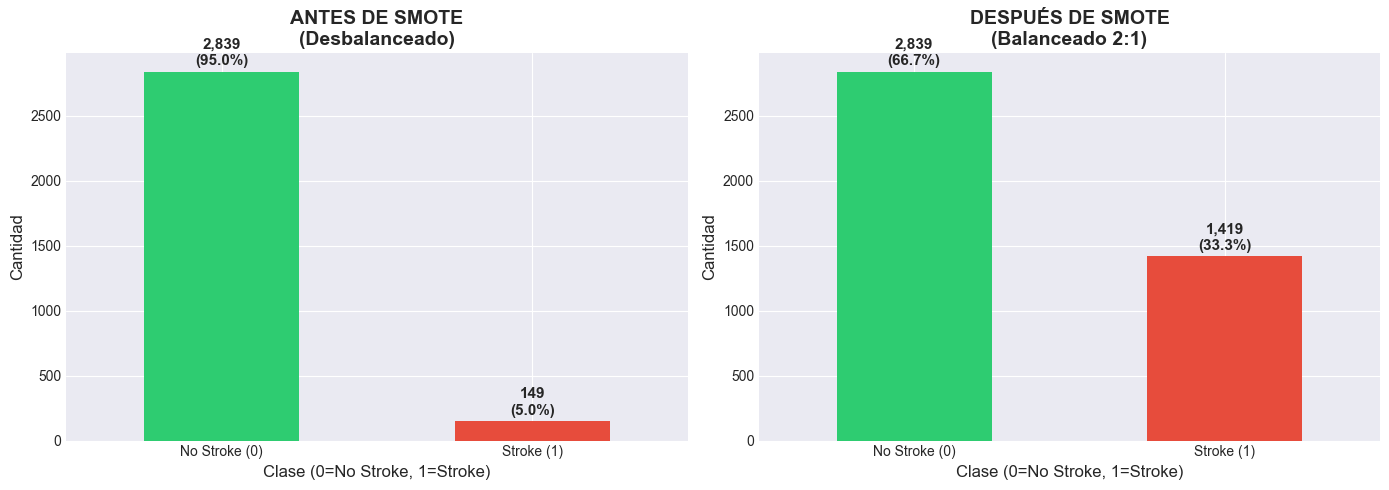

✅ Visualización guardada: backend/smote_comparison.png


In [9]:
# 📊 VISUALIZACIÓN DEL BALANCEO

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Antes de SMOTE
y_train.value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('ANTES DE SMOTE\n(Desbalanceado)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase (0=No Stroke, 1=Stroke)', fontsize=12)
axes[0].set_ylabel('Cantidad', fontsize=12)
axes[0].set_xticklabels(['No Stroke (0)', 'Stroke (1)'], rotation=0)
for i, v in enumerate(y_train.value_counts()):
    axes[0].text(i, v + 50, f"{v:,}\n({v/len(y_train)*100:.1f}%)",
                ha='center', fontweight='bold', fontsize=11)

# Después de SMOTE
pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('DESPUÉS DE SMOTE\n(Balanceado 2:1)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Clase (0=No Stroke, 1=Stroke)', fontsize=12)
axes[1].set_ylabel('Cantidad', fontsize=12)
axes[1].set_xticklabels(['No Stroke (0)', 'Stroke (1)'], rotation=0)
for i, v in enumerate(pd.Series(y_train_balanced).value_counts()):
    axes[1].text(i, v + 50, f"{v:,}\n({v/len(y_train_balanced)*100:.1f}%)",
                ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../smote_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualización guardada: backend/smote_comparison.png")

---
## 💾 FASE 7: GUARDAR DATASETS PROCESADOS
---

In [10]:
# 💾 GUARDAR DATASETS PROCESADOS

import pickle

# Crear carpeta data en backend si no existe
import os
os.makedirs('../data', exist_ok=True)

# Guardar datasets
datasets = {
    'X_train_balanced': X_train_balanced,
    'y_train_balanced': y_train_balanced,
    'X_val_scaled': X_val_scaled,
    'y_val': y_val,
    'X_test_scaled': X_test_scaled,
    'y_test': y_test,
    'scaler': scaler
}

for name, data in datasets.items():
    with open(f'../data/{name}.pkl', 'wb') as f:
        pickle.dump(data, f)
    print(f"✅ Guardado: backend/data/{name}.pkl")

print("\n💾 TODOS LOS DATASETS GUARDADOS CORRECTAMENTE")

✅ Guardado: backend/data/X_train_balanced.pkl
✅ Guardado: backend/data/y_train_balanced.pkl
✅ Guardado: backend/data/X_val_scaled.pkl
✅ Guardado: backend/data/y_val.pkl
✅ Guardado: backend/data/X_test_scaled.pkl
✅ Guardado: backend/data/y_test.pkl
✅ Guardado: backend/data/scaler.pkl

💾 TODOS LOS DATASETS GUARDADOS CORRECTAMENTE


---
## 📋 RESUMEN FINAL DEL PREPROCESAMIENTO
---

In [11]:
# 📋 RESUMEN FINAL

print("="*80)
print("🎯 RESUMEN FINAL DEL PREPROCESAMIENTO")
print("="*80)

print("\n✅ TRANSFORMACIONES APLICADAS:")
print("   1. ✓ Feature Engineering (8 nuevas features)")
print("      - age_group, glucose_category, bmi_category")
print("      - has_smoked, risk_score")
print("      - age_x_hypertension, age_x_heart_disease, glucose_x_bmi")
print("\n   2. ✓ Eliminación de features irrelevantes")
print("      - gender (correlación: 0.009)")
print("      - Residence_type (correlación: 0.016)")
print("\n   3. ✓ Encoding de categóricas")
print("      - Label Encoding: ever_married")
print("      - One-Hot Encoding: work_type, smoking_status, age_group, etc.")
print("\n   4. ✓ Split estratificado (60/20/20)")
print(f"      - Train: {len(y_train):,} filas")
print(f"      - Validation: {len(y_val):,} filas")
print(f"      - Test: {len(y_test):,} filas")
print("\n   5. ✓ Normalización (StandardScaler)")
print("      - Media ≈ 0, Std ≈ 1")
print("\n   6. ✓ Balanceo con SMOTE (ratio 2:1)")
print(f"      - Train balanceado: {len(y_train_balanced):,} filas")
print(f"      - Muestras sintéticas: {len(y_train_balanced) - len(y_train):,}")

print("\n" + "="*80)
print("📊 DATASETS FINALES:")
print("="*80)
print(f"\n🎯 TRAIN (Balanceado):")
print(f"   Shape: {X_train_balanced.shape}")
print(f"   Stroke 0: {(y_train_balanced == 0).sum():,} ({(y_train_balanced == 0).sum()/len(y_train_balanced)*100:.1f}%)")
print(f"   Stroke 1: {(y_train_balanced == 1).sum():,} ({(y_train_balanced == 1).sum()/len(y_train_balanced)*100:.1f}%)")

print(f"\n📊 VALIDATION (Original - NO balanceado):")
print(f"   Shape: {X_val_scaled.shape}")
print(f"   Stroke 0: {(y_val == 0).sum():,} ({(y_val == 0).sum()/len(y_val)*100:.1f}%)")
print(f"   Stroke 1: {(y_val == 1).sum():,} ({(y_val == 1).sum()/len(y_val)*100:.1f}%)")

print(f"\n🧪 TEST (Original - NO balanceado):")
print(f"   Shape: {X_test_scaled.shape}")
print(f"   Stroke 0: {(y_test == 0).sum():,} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"   Stroke 1: {(y_test == 1).sum():,} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

print("\n" + "="*80)
print("🏆 PREPROCESAMIENTO COMPLETADO - LISTO PARA MODELADO")
print("="*80)
print("\n🎯 PRÓXIMO PASO: Entrenar modelos baseline (Logistic Regression, Decision Tree)")

🎯 RESUMEN FINAL DEL PREPROCESAMIENTO

✅ TRANSFORMACIONES APLICADAS:
   1. ✓ Feature Engineering (8 nuevas features)
      - age_group, glucose_category, bmi_category
      - has_smoked, risk_score
      - age_x_hypertension, age_x_heart_disease, glucose_x_bmi

   2. ✓ Eliminación de features irrelevantes
      - gender (correlación: 0.009)
      - Residence_type (correlación: 0.016)

   3. ✓ Encoding de categóricas
      - Label Encoding: ever_married
      - One-Hot Encoding: work_type, smoking_status, age_group, etc.

   4. ✓ Split estratificado (60/20/20)
      - Train: 2,988 filas
      - Validation: 996 filas
      - Test: 997 filas

   5. ✓ Normalización (StandardScaler)
      - Media ≈ 0, Std ≈ 1

   6. ✓ Balanceo con SMOTE (ratio 2:1)
      - Train balanceado: 4,258 filas
      - Muestras sintéticas: 1,270

📊 DATASETS FINALES:

🎯 TRAIN (Balanceado):
   Shape: (4258, 25)
   Stroke 0: 2,839 (66.7%)
   Stroke 1: 1,419 (33.3%)

📊 VALIDATION (Original - NO balanceado):
   Shape: (99

---
## ✅ VERIFICACIÓN: LA COLUMNA `stroke` (TARGET) EXISTE
---

In [12]:
# ✅ VERIFICACIÓN: LA COLUMNA stroke (TARGET) EXISTE Y ESTÁ GUARDADA

print("="*80)
print("🎯 VERIFICACIÓN DE LA COLUMNA 'stroke' (TARGET)")
print("="*80)

print("\n📊 VARIABLE 'y' (target original):")
print(f"   Tipo: {type(y).__name__}")
print(f"   Nombre: {y.name}")
print(f"   Tamaño: {len(y):,} valores")
print(f"   Valores únicos: {sorted(y.unique())}")
print(f"\n   Distribución:")
print(y.value_counts())

print("\n📊 VARIABLE 'y_train_balanced' (target balanceado con SMOTE):")
print(f"   Tipo: {type(y_train_balanced).__name__}")
print(f"   Tamaño: {len(y_train_balanced):,} valores")
print(f"\n   Distribución:")
print(y_train_balanced.value_counts())
print(f"\n   Porcentajes:")
for value, count in y_train_balanced.value_counts().items():
    percentage = (count / len(y_train_balanced)) * 100
    print(f"      stroke={value}: {count:,} ({percentage:.1f}%)")

print("\n📊 VARIABLE 'y_val' (target validación - original):")
print(f"   Tipo: {type(y_val).__name__}")
print(f"   Tamaño: {len(y_val):,} valores")
print(f"\n   Distribución:")
print(y_val.value_counts())

print("\n📊 VARIABLE 'y_test' (target test - original):")
print(f"   Tipo: {type(y_test).__name__}")
print(f"   Tamaño: {len(y_test):,} valores")
print(f"\n   Distribución:")
print(y_test.value_counts())

print("\n" + "="*80)
print("✅ CONFIRMADO: La columna 'stroke' EXISTE y está separada como TARGET (y)")
print("="*80)
print("\n🎯 RESUMEN:")
print("   - X (features): NO contiene 'stroke' - Solo características de pacientes")
print("   - y (target): SÍ contiene 'stroke' - Lo que queremos predecir")
print("   - stroke = 0: Paciente NO tuvo ictus")
print("   - stroke = 1: Paciente SÍ tuvo ictus")
print("\n💡 Los modelos aprenderán de X para predecir y")

🎯 VERIFICACIÓN DE LA COLUMNA 'stroke' (TARGET)

📊 VARIABLE 'y' (target original):
   Tipo: Series
   Nombre: stroke
   Tamaño: 4,981 valores
   Valores únicos: [0, 1]

   Distribución:
stroke
0    4733
1     248
Name: count, dtype: int64

📊 VARIABLE 'y_train_balanced' (target balanceado con SMOTE):
   Tipo: Series
   Tamaño: 4,258 valores

   Distribución:
stroke
0    2839
1    1419
Name: count, dtype: int64

   Porcentajes:
      stroke=0: 2,839 (66.7%)
      stroke=1: 1,419 (33.3%)

📊 VARIABLE 'y_val' (target validación - original):
   Tipo: Series
   Tamaño: 996 valores

   Distribución:
stroke
0    947
1     49
Name: count, dtype: int64

📊 VARIABLE 'y_test' (target test - original):
   Tipo: Series
   Tamaño: 997 valores

   Distribución:
stroke
0    947
1     50
Name: count, dtype: int64

✅ CONFIRMADO: La columna 'stroke' EXISTE y está separada como TARGET (y)

🎯 RESUMEN:
   - X (features): NO contiene 'stroke' - Solo características de pacientes
   - y (target): SÍ contiene 'stro

---
## ✅ VERIFICACIÓN FINAL: LISTO PARA ENTRENAR MODELO
### Verificar que todos los datos estén correctamente preparados
---


In [14]:
# ✅ VERIFICACIÓN COMPLETA ANTES DE ENTRENAR MODELO

print("="*80)
print("🔍 VERIFICACIÓN FINAL: LISTO PARA ENTRENAR RANDOM FOREST")
print("="*80)

# Lista de variables requeridas
required_vars = {
    'X_train_balanced': X_train_balanced,
    'y_train_balanced': y_train_balanced,
    'X_val_scaled': X_val_scaled,
    'y_val': y_val,
    'X_test_scaled': X_test_scaled,
    'y_test': y_test,
    'scaler': scaler
}

all_checks_passed = True

print("\n1️⃣ VERIFICACIÓN DE VARIABLES EN MEMORIA:")
print("-" * 80)
for var_name, var_value in required_vars.items():
    try:
        if var_value is not None:
            print(f"   ✅ {var_name}: Existe")
        else:
            print(f"   ❌ {var_name}: Es None")
            all_checks_passed = False
    except NameError:
        print(f"   ❌ {var_name}: NO EXISTE en memoria")
        all_checks_passed = False

print("\n2️⃣ VERIFICACIÓN DE SHAPES:")
print("-" * 80)
expected_shapes = {
    'X_train_balanced': (4258, 25),
    'y_train_balanced': (4258,),
    'X_val_scaled': (996, 25),
    'y_val': (996,),
    'X_test_scaled': (997, 25),
    'y_test': (997,)
}

for var_name, expected_shape in expected_shapes.items():
    try:
        actual_shape = required_vars[var_name].shape
        if actual_shape == expected_shape:
            print(f"   ✅ {var_name}: {actual_shape} (correcto)")
        else:
            print(f"   ⚠️  {var_name}: {actual_shape} (esperado: {expected_shape})")
            all_checks_passed = False
    except:
        print(f"   ❌ {var_name}: No se puede verificar shape")
        all_checks_passed = False

print("\n3️⃣ VERIFICACIÓN DE TIPOS DE DATOS:")
print("-" * 80)
# Verificar que X sean DataFrames o arrays numéricos
for var_name in ['X_train_balanced', 'X_val_scaled', 'X_test_scaled']:
    try:
        var = required_vars[var_name]
        if hasattr(var, 'dtypes'):
            # Es DataFrame
            non_numeric = var.select_dtypes(exclude=[np.number]).columns.tolist()
            if len(non_numeric) == 0:
                print(f"   ✅ {var_name}: Todas las features son numéricas")
            else:
                print(f"   ❌ {var_name}: Features no numéricas encontradas: {non_numeric}")
                all_checks_passed = False
        elif hasattr(var, 'dtype'):
            # Es array numpy
            if np.issubdtype(var.dtype, np.number):
                print(f"   ✅ {var_name}: Array numérico")
            else:
                print(f"   ❌ {var_name}: No es numérico")
                all_checks_passed = False
    except Exception as e:
        print(f"   ❌ {var_name}: Error al verificar tipos - {str(e)}")
        all_checks_passed = False

print("\n4️⃣ VERIFICACIÓN DE VALORES NULOS:")
print("-" * 80)
for var_name in ['X_train_balanced', 'X_val_scaled', 'X_test_scaled']:
    try:
        var = required_vars[var_name]
        if hasattr(var, 'isnull'):
            null_count = var.isnull().sum().sum()
        else:
            null_count = np.isnan(var).sum()
        
        if null_count == 0:
            print(f"   ✅ {var_name}: Sin valores nulos")
        else:
            print(f"   ⚠️  {var_name}: {null_count} valores nulos encontrados")
            all_checks_passed = False
    except Exception as e:
        print(f"   ❌ {var_name}: Error al verificar nulos - {str(e)}")
        all_checks_passed = False

print("\n5️⃣ VERIFICACIÓN DE TARGETS (y):")
print("-" * 80)
for var_name in ['y_train_balanced', 'y_val', 'y_test']:
    try:
        var = required_vars[var_name]
        unique_values = sorted(var.unique())
        if set(unique_values) == {0, 1}:
            print(f"   ✅ {var_name}: Binario correcto [0, 1]")
            print(f"      Distribución: {var.value_counts().to_dict()}")
        else:
            print(f"   ❌ {var_name}: Valores incorrectos: {unique_values}")
            all_checks_passed = False
    except Exception as e:
        print(f"   ❌ {var_name}: Error al verificar - {str(e)}")
        all_checks_passed = False

print("\n6️⃣ VERIFICACIÓN DE BALANCEO:")
print("-" * 80)
try:
    train_ratio = (y_train_balanced == 0).sum() / (y_train_balanced == 1).sum()
    print(f"   ✅ Train balanceado: Ratio {train_ratio:.2f}:1 (esperado ~2:1)")
    
    val_ratio = (y_val == 0).sum() / (y_val == 1).sum()
    print(f"   ✅ Validation original: Ratio {val_ratio:.2f}:1 (desbalanceado, correcto)")
    
    test_ratio = (y_test == 0).sum() / (y_test == 1).sum()
    print(f"   ✅ Test original: Ratio {test_ratio:.2f}:1 (desbalanceado, correcto)")
except Exception as e:
    print(f"   ❌ Error al verificar balanceo: {str(e)}")
    all_checks_passed = False

print("\n7️⃣ VERIFICACIÓN DE SCALER:")
print("-" * 80)
try:
    if scaler is not None:
        print(f"   ✅ Scaler existe: {type(scaler).__name__}")
        print(f"      Media aprendida: {scaler.mean_[:5] if hasattr(scaler, 'mean_') else 'N/A'}")
        print(f"      Std aprendida: {scaler.scale_[:5] if hasattr(scaler, 'scale_') else 'N/A'}")
    else:
        print(f"   ❌ Scaler es None")
        all_checks_passed = False
except Exception as e:
    print(f"   ❌ Error al verificar scaler: {str(e)}")
    all_checks_passed = False

print("\n" + "="*80)
if all_checks_passed:
    print("🎉 ¡TODAS LAS VERIFICACIONES PASARON!")
    print("✅ EL DATASET ESTÁ LISTO PARA ENTRENAR RANDOM FOREST")
    print("\n📋 RESUMEN:")
    print(f"   • Features: {X_train_balanced.shape[1]} variables numéricas")
    print(f"   • Train: {X_train_balanced.shape[0]:,} muestras (balanceado)")
    print(f"   • Validation: {X_val_scaled.shape[0]:,} muestras (original)")
    print(f"   • Test: {X_test_scaled.shape[0]:,} muestras (original)")
    print("\n🚀 PRÓXIMO PASO: Entrenar Random Forest con Optuna + K-Folds")
else:
    print("⚠️  ALGUNAS VERIFICACIONES FALLARON")
    print("❌ REVISAR LOS ERRORES ARRIBA ANTES DE ENTRENAR")
print("="*80)


🔍 VERIFICACIÓN FINAL: LISTO PARA ENTRENAR RANDOM FOREST

1️⃣ VERIFICACIÓN DE VARIABLES EN MEMORIA:
--------------------------------------------------------------------------------
   ✅ X_train_balanced: Existe
   ✅ y_train_balanced: Existe
   ✅ X_val_scaled: Existe
   ✅ y_val: Existe
   ✅ X_test_scaled: Existe
   ✅ y_test: Existe
   ✅ scaler: Existe

2️⃣ VERIFICACIÓN DE SHAPES:
--------------------------------------------------------------------------------
   ✅ X_train_balanced: (4258, 25) (correcto)
   ✅ y_train_balanced: (4258,) (correcto)
   ✅ X_val_scaled: (996, 25) (correcto)
   ✅ y_val: (996,) (correcto)
   ✅ X_test_scaled: (997, 25) (correcto)
   ✅ y_test: (997,) (correcto)

3️⃣ VERIFICACIÓN DE TIPOS DE DATOS:
--------------------------------------------------------------------------------
   ✅ X_train_balanced: Todas las features son numéricas
   ✅ X_val_scaled: Todas las features son numéricas
   ✅ X_test_scaled: Todas las features son numéricas

4️⃣ VERIFICACIÓN DE VALORES N